# Problem 1: Predicting Number of Attacks Next Month

## Checking pre prerequisites before starting to build the model

In [320]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme (style="darkgrid")


In [321]:
# Load the dataset
df = pd.read_csv("linear_regression_dataset.csv")

prob1_dataset = df

In [322]:
# One hot encoding the model column as it is an object dt which the model cannot read
prob1_dataset = pd.get_dummies(prob1_dataset, columns=['model'])


In [323]:
# Dropping all null values
prob1_dataset = prob1_dataset.dropna()

## Training the model

In [309]:
# Setting features and target
X = prob1_dataset.drop(columns=['launched','launched_next_month'])
y = prob1_dataset['launched_next_month']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)


# Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:time_start: object

In [318]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Features and target
X = prob1_dataset.drop(columns=['launched', 'launched_next_month', 'time_start'])
y = prob1_dataset['launched_next_month']

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []
r2_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"Fold {fold} RMSE: {rmse:.2f}, R²: {r2:.4f}")

print("\n=== Overall Performance ===")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average R²: {np.mean(r2_scores):.4f}")


Fold 1 RMSE: 45.39, R²: -0.6414
Fold 2 RMSE: 24.39, R²: -6.2076
Fold 3 RMSE: 32.18, R²: -10.0141
Fold 4 RMSE: 26.23, R²: -3.0867
Fold 5 RMSE: 13.85, R²: -0.2235

=== Overall Performance ===
Average RMSE: 28.41
Average R²: -4.0347


Test RMSE: 13.18
Test R²: -0.0784


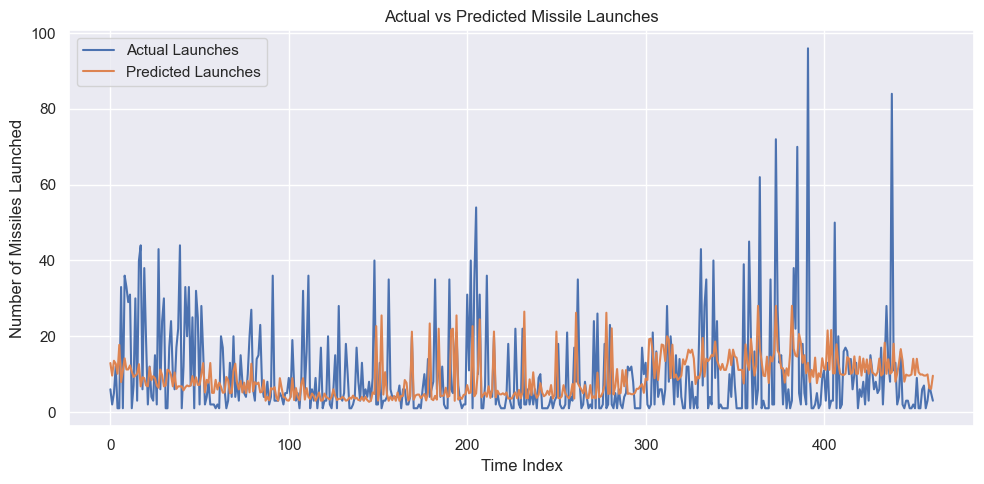

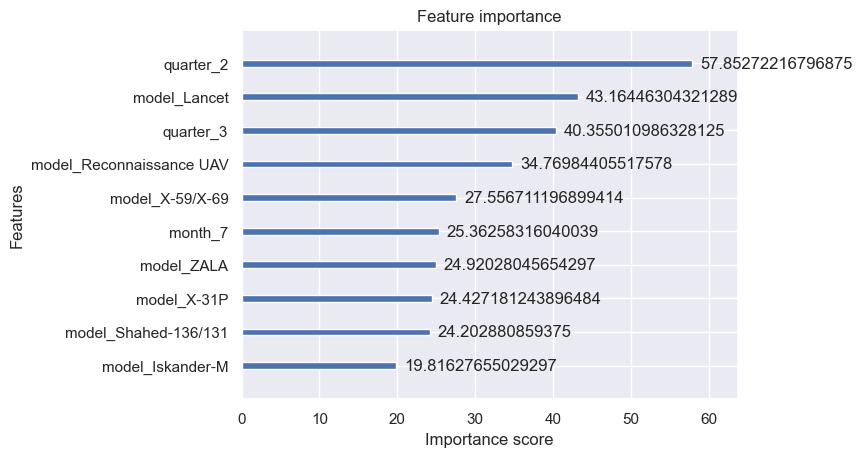

In [325]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 0: Ensure time_start is datetime
prob1_dataset['time_start'] = pd.to_datetime(prob1_dataset['time_start'])

# Step 0.5: Extract and one-hot encode time-based features
prob1_dataset['month'] = prob1_dataset['time_start'].dt.month
prob1_dataset['quarter'] = prob1_dataset['time_start'].dt.quarter

# One-hot encode 'month' and 'quarter'
prob1_dataset = pd.get_dummies(prob1_dataset, columns=['month', 'quarter'], drop_first=True)

# Step 1: Prepare features and log-transformed target
X = prob1_dataset.drop(columns=['launched', 'launched_next_month', 'time_start'])
y_raw = prob1_dataset['launched_next_month']
y_log = np.log1p(y_raw)

# Step 2: Time-aware train-test split
X_train, X_test, y_train_log, y_test_log, y_train_raw, y_test_raw = train_test_split(
    X, y_log, y_raw, test_size=0.2, shuffle=False
)

# Step 3: Sample weights to emphasize larger values
sample_weights = np.log1p(y_train_raw)

# Step 4: Best hyperparameters from tuning
best_params = {
    'subsample': 0.8,
    'reg_lambda': 1.5,
    'reg_alpha': 0.1,
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.03,
    'colsample_bytree': 1.0,
    'random_state': 42
}

# Step 5: Train model
model = XGBRegressor(**best_params)
model.fit(X_train, y_train_log, sample_weight=sample_weights)

# Step 6: Predict & inverse transform
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)   # reverse the log1p
y_actual = y_test_raw.values

# Step 7: Evaluate
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.4f}")

# Step 8: Plot predictions vs actual
plt.figure(figsize=(10, 5))
plt.plot(y_actual, label='Actual Launches')
plt.plot(y_pred, label='Predicted Launches')
plt.title('Actual vs Predicted Missile Launches')
plt.xlabel('Time Index')
plt.ylabel('Number of Missiles Launched')
plt.legend()
plt.tight_layout()
plt.show()

# Step 9: Feature importance
plot_importance(model, max_num_features=10, importance_type='gain')
plt.show()


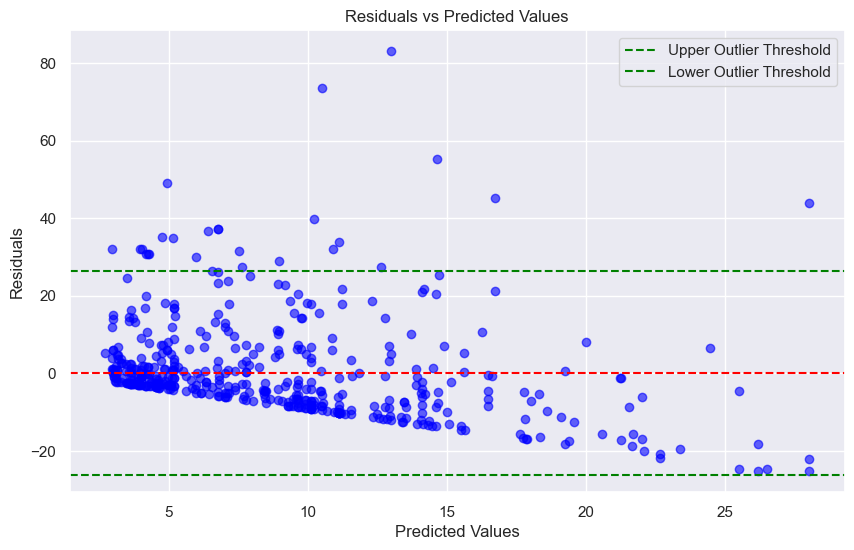

RMSE: 13.18


In [326]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_actual - y_pred

# Plotting
plt.figure(figsize=(10, 6))

# Residuals vs Predicted values plot
plt.scatter(y_pred, residuals, color='blue', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Optional: Add lines to identify outliers (this is one way to define outliers, e.g., beyond 2 standard deviations)
std_residuals = np.std(residuals)
outlier_threshold_upper = std_residuals * 2
outlier_threshold_lower = -std_residuals * 2

plt.axhline(y=outlier_threshold_upper, color='green', linestyle='--', label='Upper Outlier Threshold')
plt.axhline(y=outlier_threshold_lower, color='green', linestyle='--', label='Lower Outlier Threshold')

plt.legend()
plt.show()

# Print RMSE
print(f"RMSE: {rmse:.2f}")
